In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [3]:
# map to root
import sys
project_root = Path.cwd().parent

df = pd.read_parquet(project_root / "data" / "final" / "core_2021-01-01_2025-12-31.parquet")

sys.path.append(str(project_root / "src"))

df.head()

,intraday_wap,da_price,wind_outturn,wind_forecast_ng,solar_outturn,solar_forecast_ng,hour_sin,hour_cos,dow_sin,dow_cos,is_weekend,intraday_wap_rollmean_4,intraday_wap_rollstd_4,intraday_wap_rollmean_12,intraday_wap_rollstd_12,da_price_rollmean_4,da_price_rollstd_4,da_price_rollmean_12,da_price_rollstd_12
timestamp,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,80.32,74.00,4420.0,4341.0,0.0,0.0,0.000000,1.000000,-0.433884,-0.900969,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:00:00+00:00,77.20,71.29,4261.7,4398.0,0.0,0.0,0.258819,0.965926,-0.433884,-0.900969,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 02:00:00+00:00,62.92,65.32,4415.7,4465.0,0.0,0.0,0.500000,0.866025,-0.433884,-0.900969,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 03:00:00+00:00,53.29,57.26,4404.2,4604.0,0.0,0.0,0.707107,0.707107,-0.433884,-0.900969,False,68.4325,12.620944,NaN,NaN,66.9675,7.418218,NaN,NaN
2021-01-01 04:00:00+00:00,62.77,54.91,4537.3,4748.0,0.0,0.0,0.866025,0.500000,-0.433884,-0.900969,False,64.0450,9.859265,NaN,NaN,62.1950,7.525736,NaN,NaN


In [4]:
df.describe()

,intraday_wap,da_price,wind_outturn,wind_forecast_ng,solar_outturn,solar_forecast_ng,hour_sin,hour_cos,dow_sin,dow_cos,intraday_wap_rollmean_4,intraday_wap_rollstd_4,intraday_wap_rollmean_12,intraday_wap_rollstd_12,da_price_rollmean_4,da_price_rollstd_4,da_price_rollmean_12,da_price_rollstd_12
count,43717.000000,43717.000000,43717.000000,43717.000000,43717.000000,43717.000000,43717.000000,4.371700e+04,43717.000000,43717.000000,43702.000000,43702.000000,43662.000000,43662.000000,43702.000000,43702.000000,43662.000000,43662.000000
mean,129.758197,133.317944,7037.968353,7741.235446,1540.612627,1492.681314,-0.000181,-4.642677e-04,-0.001036,0.000169,129.782825,19.161815,129.843101,30.292043,133.340774,15.968964,133.392816,28.404958
std,102.431315,102.092467,4238.339409,4883.310048,2424.841266,2295.765045,0.707176,7.070536e-01,0.707067,0.707162,97.043644,32.674789,90.020242,41.121291,97.362352,31.690785,90.789594,39.675757
min,-115.530000,-59.970000,0.000000,317.000000,0.000000,0.000000,-1.000000,-1.000000e+00,-0.974928,-0.900969,-86.315000,0.188922,-38.167500,2.263405,-44.192500,0.065511,-26.226667,0.853135
25%,79.690000,81.620000,3434.900000,3609.000000,0.000000,0.000000,-0.707107,-7.071068e-01,-0.781831,-0.900969,80.750000,7.524747,81.687708,14.379091,82.440000,5.514893,83.809583,13.446118
50%,104.300000,104.330000,6455.300000,6899.000000,24.000000,96.000000,0.000000,-1.836970e-16,0.000000,-0.222521,104.152500,13.099649,103.412083,21.604583,104.285000,10.236406,102.571667,18.963740
75%,151.260000,153.180000,10440.000000,11372.000000,2456.400000,2356.500000,0.707107,7.071068e-01,0.781831,0.623490,150.790000,22.927791,150.027917,35.882410,152.544375,17.862281,151.947292,31.283320
max,3859.630000,2569.580000,18321.000000,21579.000000,13943.000000,13878.000000,1.000000,1.000000e+00,0.974928,1.000000,2509.332500,1631.272117,1626.975833,1201.864641,1738.005000,1130.394570,1004.721667,837.101828


In [5]:
from config import TARGET_COL
print("\n" + "="*60)
print("DATA QUALITY ASSESSMENT")
print("="*60)

# 1. Missing values
print("\n📊 Missing Values Count:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing[missing > 0],
    'Missing %': missing_pct[missing > 0]
}).sort_values('Missing Count', ascending=False)
if len(missing_df) > 0:
    print(missing_df)
    print(f"\n⚠️  Total rows with any missing: {df.isnull().any(axis=1).sum()} ({(df.isnull().any(axis=1).sum()/len(df)*100):.2f}%)")
else:
    print("✓ No missing values detected")

# 2. Check for gaps in time series (missing hours)
expected_freq = pd.Timedelta(hours=1)
time_diffs = df.index.to_series().diff()
gaps = time_diffs[time_diffs > expected_freq]

print(f"\n🕐 Time Series Continuity:")
print(f"  Expected frequency: 1 hour")
print(f"  Total observations: {len(df)}")
print(f"  Date range span: {(df.index.max() - df.index.min()).days} days")
print(f"  Expected hours: {(df.index.max() - df.index.min()).total_seconds() / 3600:.0f}")
print(f"  Actual hours: {len(df)}")
print(f"  Missing hours: {((df.index.max() - df.index.min()).total_seconds() / 3600) - len(df):.0f}")

if len(gaps) > 0:
    print(f"\n⚠️  Found {len(gaps)} gaps in time series:")
    print(f"  Largest gap: {gaps.max()}")
    print(f"  First 5 gaps:")
    for idx, gap in gaps.head().items():
        print(f"    {idx}: {gap} gap")
else:
    print("✓ No gaps detected - continuous hourly data")

# 3. Duplicate timestamps
duplicates = df.index.duplicated().sum()
print(f"\n🔁 Duplicate Timestamps:")
if duplicates > 0:
    print(f"⚠️  Found {duplicates} duplicate timestamps")
    print(f"  First duplicates:")
    print(df[df.index.duplicated(keep=False)].head(10))
else:
    print("✓ No duplicate timestamps")

# 4. Outliers detection (using IQR method)
print(f"\n📈 Outlier Detection (IQR method):")
for col in [TARGET_COL, 'wind_outturn', 'solar_outturn']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outliers_pct = (outliers / len(df)) * 100
    
    print(f"  {col}:")
    print(f"    Range: [{df[col].min():.2f}, {df[col].max():.2f}]")
    print(f"    IQR bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"    Outliers: {outliers} ({outliers_pct:.2f}%)")

# 5. Zero/negative values check (for prices)
print(f"\n💰 Price Value Checks:")
zero_prices = (df[TARGET_COL] == 0).sum()
negative_prices = (df[TARGET_COL] < 0).sum()
print(f"  Zero prices: {zero_prices} ({(zero_prices/len(df)*100):.2f}%)")
print(f"  Negative prices: {negative_prices} ({(negative_prices/len(df)*100):.2f}%)")
if negative_prices > 0:
    print(f"    Min price: {df[TARGET_COL].min():.2f} EUR/MWh")
    print(f"    Negative price dates (first 5):")
    print(df[df[TARGET_COL] < 0].head()[TARGET_COL])

# 6. Constant values (stuck sensors/forward fill artifacts)
print(f"\n🔒 Constant Value Sequences:")
for col in [TARGET_COL, 'wind_outturn', 'solar_outturn']:
    # Find sequences of identical values
    constant_runs = (df[col] == df[col].shift()).sum()
    max_run = (df[col].diff() == 0).astype(int).groupby(
        (df[col].diff() != 0).cumsum()
    ).sum().max() if len(df) > 1 else 0
    
    print(f"  {col}:")
    print(f"    Consecutive identical values: {constant_runs} ({(constant_runs/len(df)*100):.2f}%)")
    print(f"    Longest run: {max_run} hours")

print("\n" + "="*60)


DATA QUALITY ASSESSMENT

📊 Missing Values Count:
                          Missing Count  Missing %
intraday_wap_rollstd_12              55   0.125809
intraday_wap_rollmean_12             55   0.125809
da_price_rollmean_12                 55   0.125809
da_price_rollstd_12                  55   0.125809
intraday_wap_rollmean_4              15   0.034312
intraday_wap_rollstd_4               15   0.034312
da_price_rollstd_4                   15   0.034312
da_price_rollmean_4                  15   0.034312

⚠️  Total rows with any missing: 55 (0.13%)

🕐 Time Series Continuity:
  Expected frequency: 1 hour
  Total observations: 43717
  Date range span: 1825 days
  Expected hours: 43800
  Actual hours: 43717
  Missing hours: 83

⚠️  Found 21 gaps in time series:
  Largest gap: 1 days 00:00:00
  First 5 gaps:
    2021-01-26 23:00:00+00:00: 1 days 00:00:00 gap
    2021-01-28 23:00:00+00:00: 0 days 14:00:00 gap
    2021-03-09 10:00:00+00:00: 0 days 02:00:00 gap
    2021-05-15 07:00:00+00:00: 0

In [6]:
# Calculate returns for GARCH analysis
df['returns'] = df[TARGET_COL].pct_change()
df['log_returns'] = np.log(df[TARGET_COL] / df[TARGET_COL].shift(1))
df = df.dropna(subset=['returns', 'log_returns'])

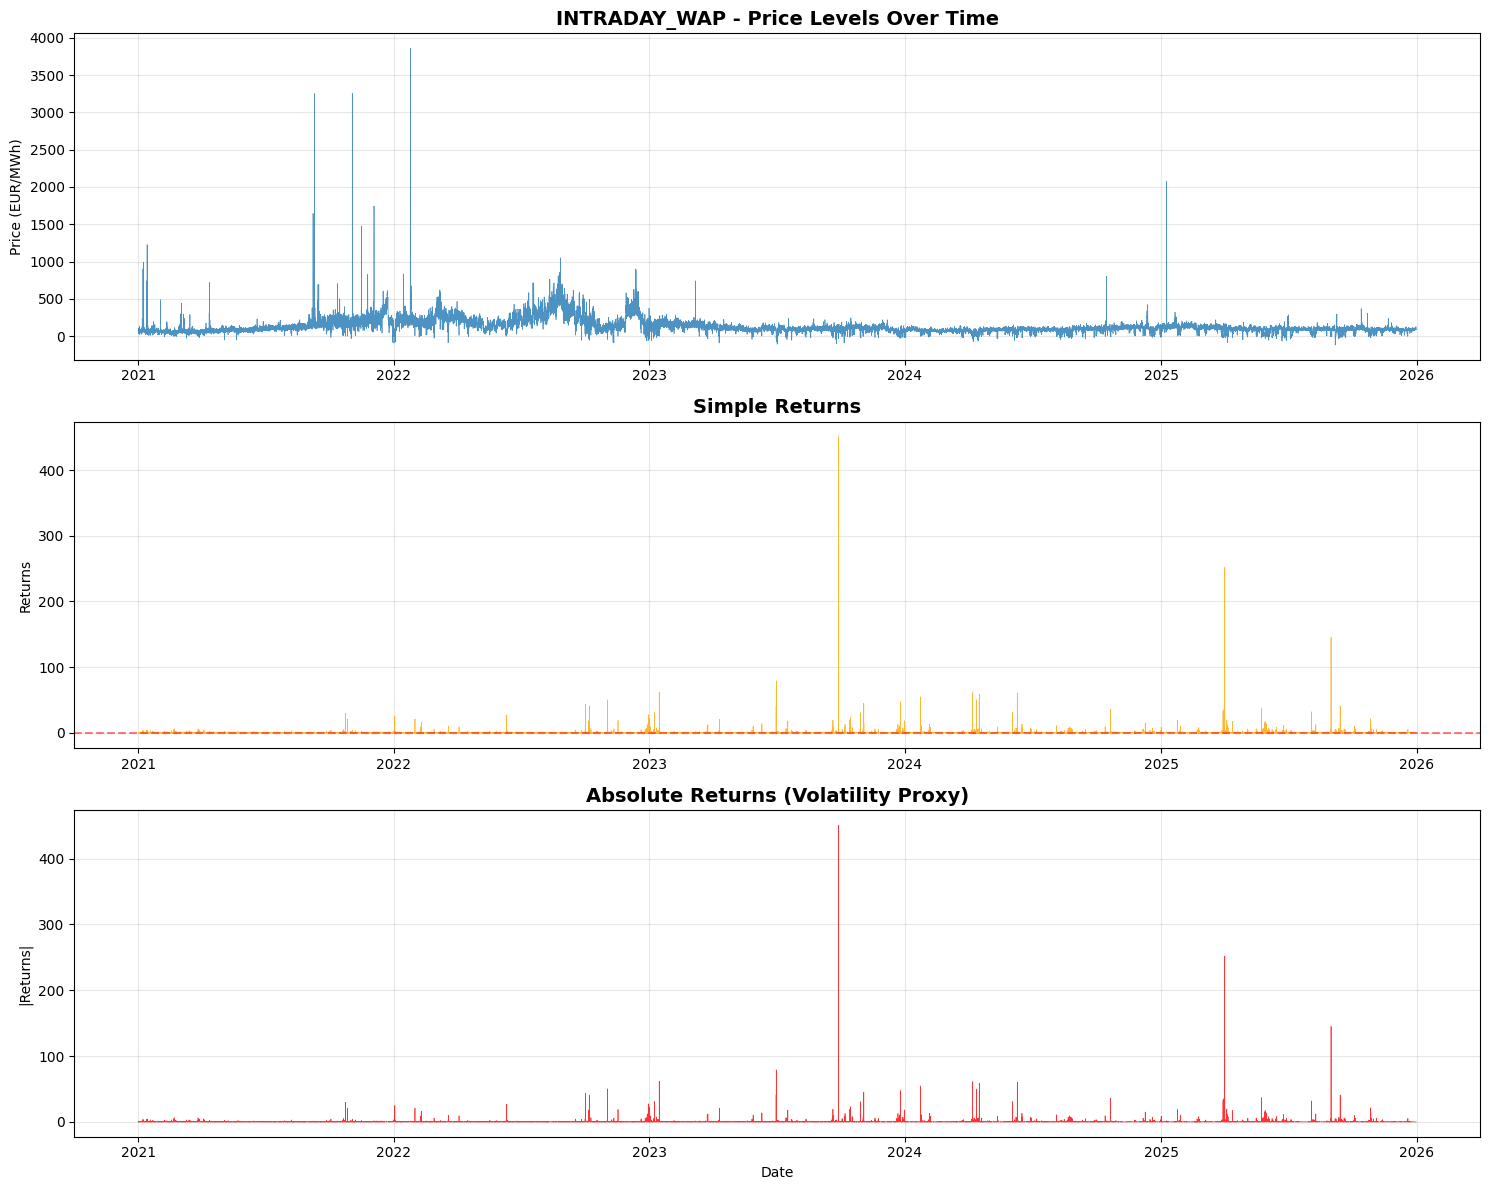

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Price levels
axes[0].plot(df.index, df[TARGET_COL], linewidth=0.5, alpha=0.8)
axes[0].set_title(f'{TARGET_COL.upper()} - Price Levels Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (EUR/MWh)')
axes[0].grid(True, alpha=0.3)

# Returns
axes[1].plot(df.index, df['returns'], linewidth=0.5, alpha=0.8, color='orange')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_title('Simple Returns', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Returns')
axes[1].grid(True, alpha=0.3)

# Absolute returns (volatility proxy)
axes[2].plot(df.index, np.abs(df['returns']), linewidth=0.5, alpha=0.8, color='red')
axes[2].set_title('Absolute Returns (Volatility Proxy)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('|Returns|')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'eda' / '01_time_series_overview.png', dpi=300, bbox_inches='tight')
plt.show()


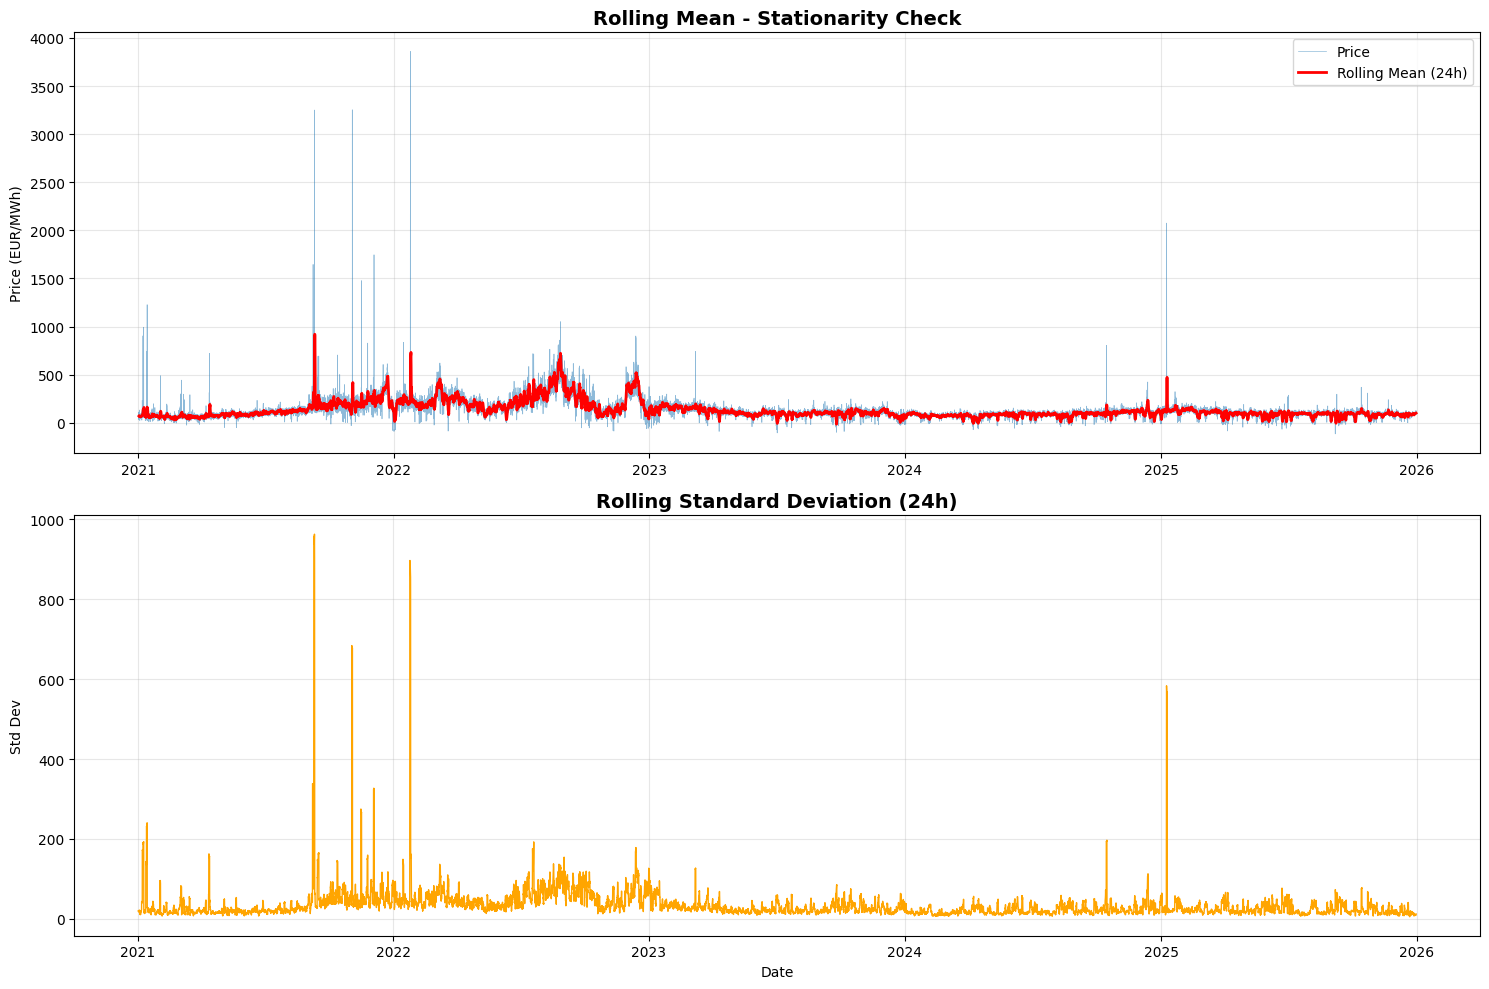

In [8]:
# Calculate rolling mean and std (24-hour window)
rolling_mean = df[TARGET_COL].rolling(window=24).mean()
rolling_std = df[TARGET_COL].rolling(window=24).std()

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Rolling mean
axes[0].plot(df.index, df[TARGET_COL], label='Price', alpha=0.5, linewidth=0.5)
axes[0].plot(df.index, rolling_mean, label='Rolling Mean (24h)', color='red', linewidth=2)
axes[0].set_title('Rolling Mean - Stationarity Check', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (EUR/MWh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rolling std
axes[1].plot(df.index, rolling_std, color='orange', linewidth=1)
axes[1].set_title('Rolling Standard Deviation (24h)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Std Dev')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'eda' / '02_stationarity_check.png', dpi=300, bbox_inches='tight')
plt.show()

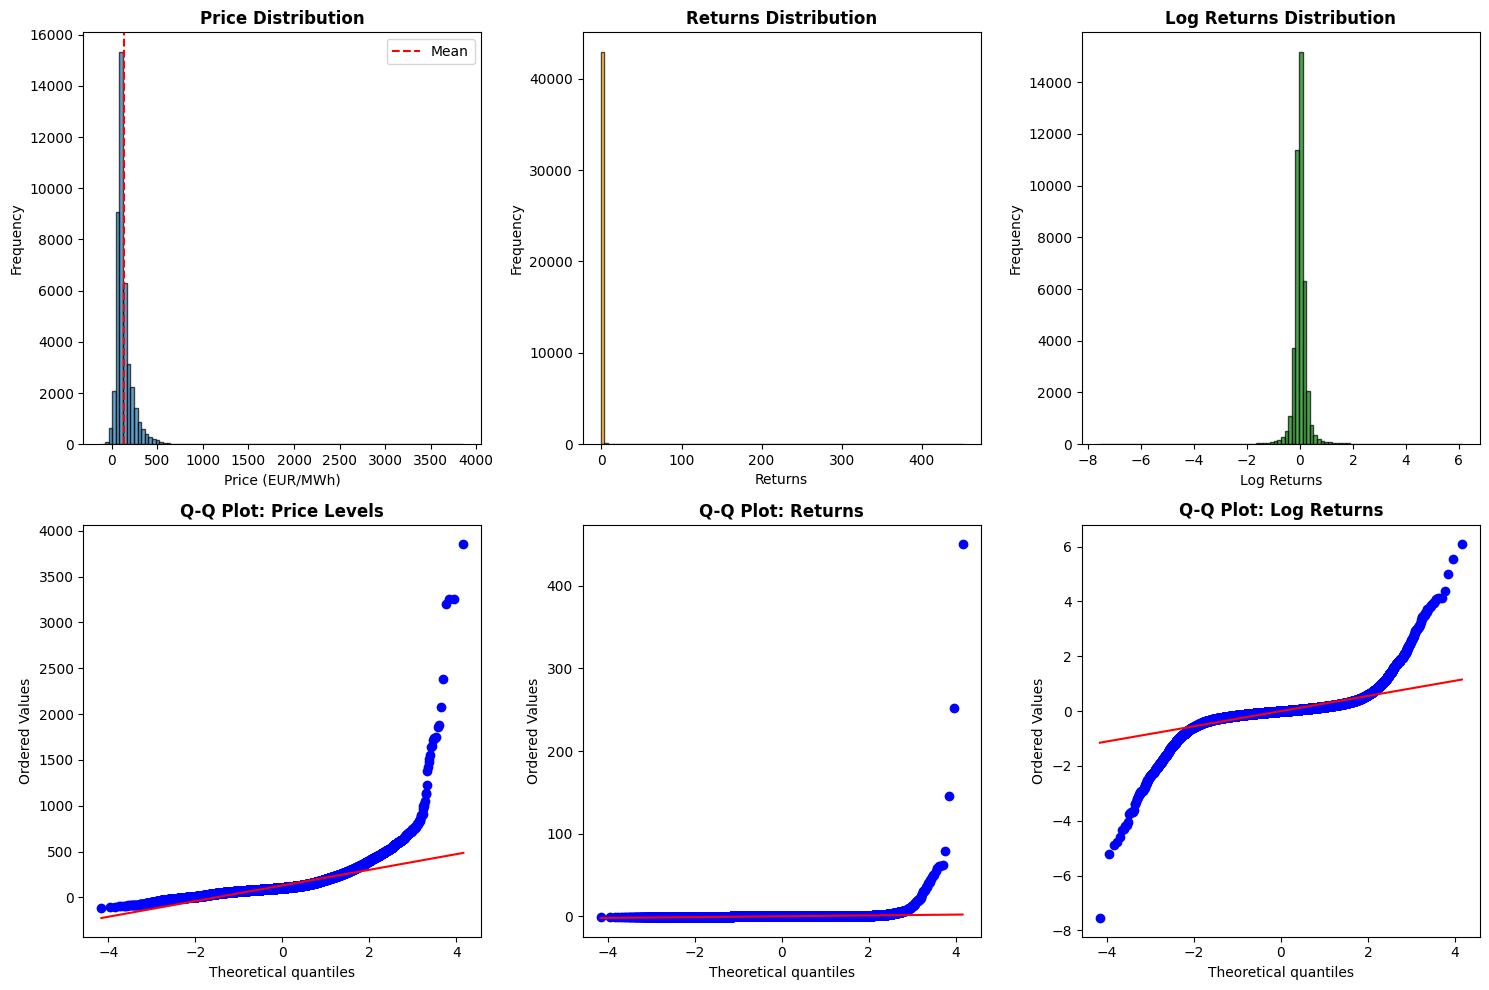


Kurtosis (>3 indicates fat tails, good for GARCH):
Price levels: 129.89
Returns: 15446.63
Log returns: 45.21


In [9]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Price distribution
axes[0, 0].hist(df[TARGET_COL], bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Price Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Price (EUR/MWh)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df[TARGET_COL].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# Returns distribution
axes[0, 1].hist(df['returns'], bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Returns Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Returns')
axes[0, 1].set_ylabel('Frequency')

# Log returns distribution
axes[0, 2].hist(df['log_returns'], bins=100, edgecolor='black', alpha=0.7, color='green')
axes[0, 2].set_title('Log Returns Distribution', fontweight='bold')
axes[0, 2].set_xlabel('Log Returns')
axes[0, 2].set_ylabel('Frequency')

# QQ plots
stats.probplot(df[TARGET_COL], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Price Levels', fontweight='bold')

stats.probplot(df['returns'].dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot: Returns', fontweight='bold')

stats.probplot(df['log_returns'].dropna(), dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('Q-Q Plot: Log Returns', fontweight='bold')

plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'eda' / '03_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print kurtosis (fat tails indicator)
print(f"\nKurtosis (>3 indicates fat tails, good for GARCH):")
print(f"Price levels: {stats.kurtosis(df[TARGET_COL]):.2f}")
print(f"Returns: {stats.kurtosis(df['returns'].dropna()):.2f}")
print(f"Log returns: {stats.kurtosis(df['log_returns'].dropna()):.2f}")

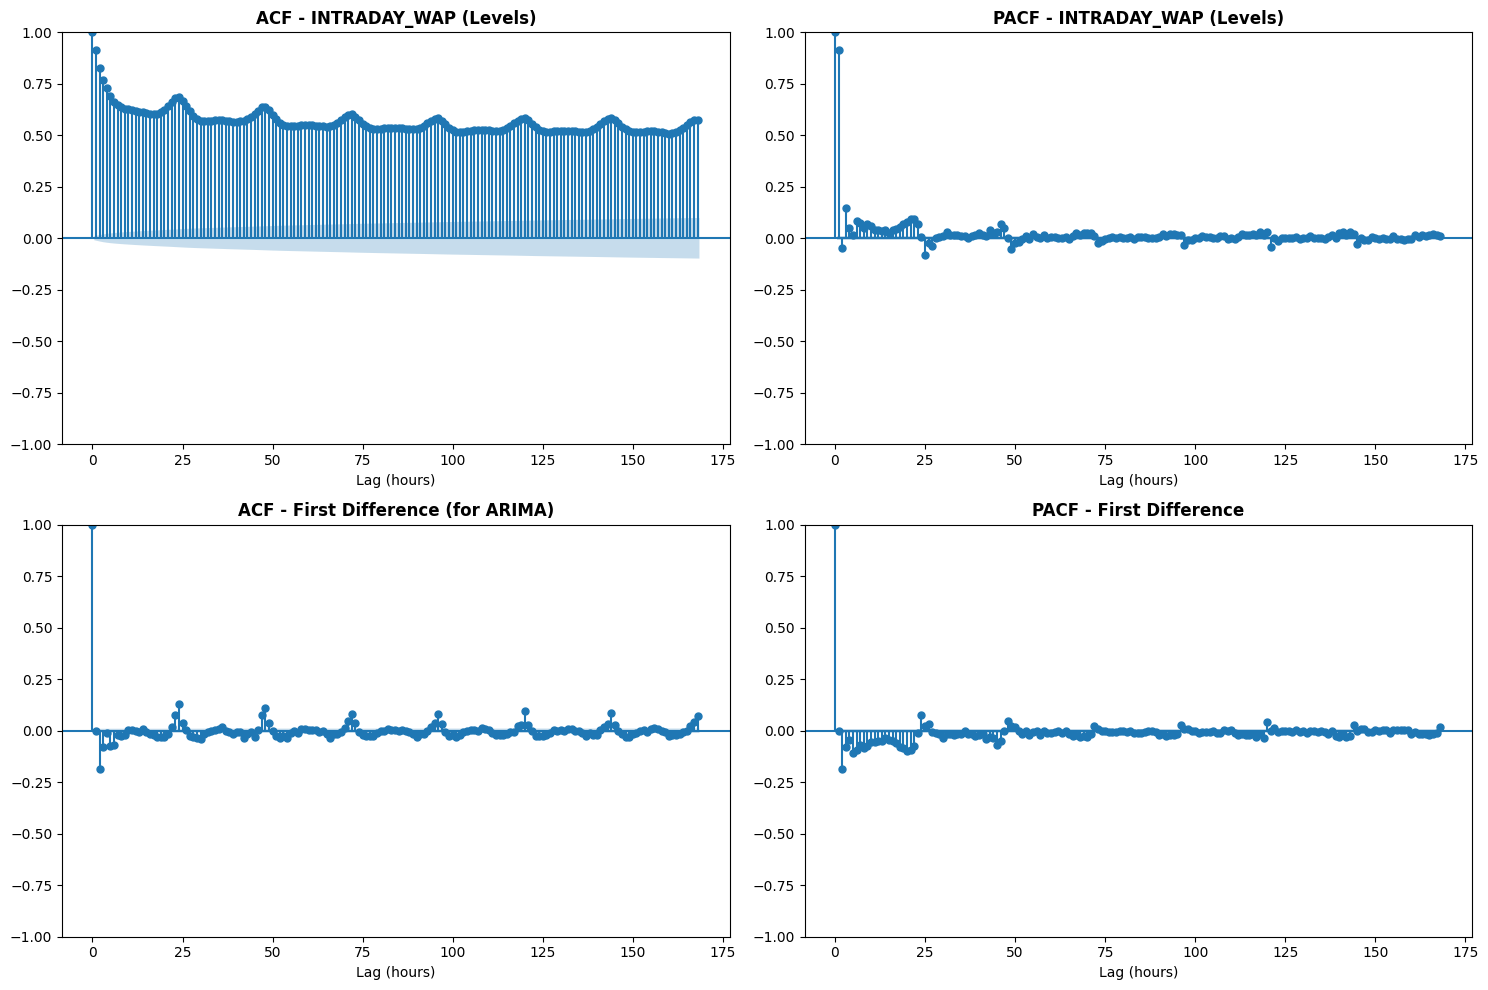

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ACF - Price levels
plot_acf(df[TARGET_COL], lags=168, ax=axes[0, 0], alpha=0.05)
axes[0, 0].set_title(f'ACF - {TARGET_COL.upper()} (Levels)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Lag (hours)')

# PACF - Price levels
plot_pacf(df[TARGET_COL], lags=168, ax=axes[0, 1], alpha=0.05, method='ywm')
axes[0, 1].set_title(f'PACF - {TARGET_COL.upper()} (Levels)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Lag (hours)')

# ACF - First difference
price_diff = df[TARGET_COL].diff().dropna()
plot_acf(price_diff, lags=168, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('ACF - First Difference (for ARIMA)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Lag (hours)')

# PACF - First difference
plot_pacf(price_diff, lags=168, ax=axes[1, 1], alpha=0.05, method='ywm')
axes[1, 1].set_title('PACF - First Difference', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Lag (hours)')

plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'eda' / '04_acf_pacf_levels.png', dpi=300, bbox_inches='tight')
plt.show()

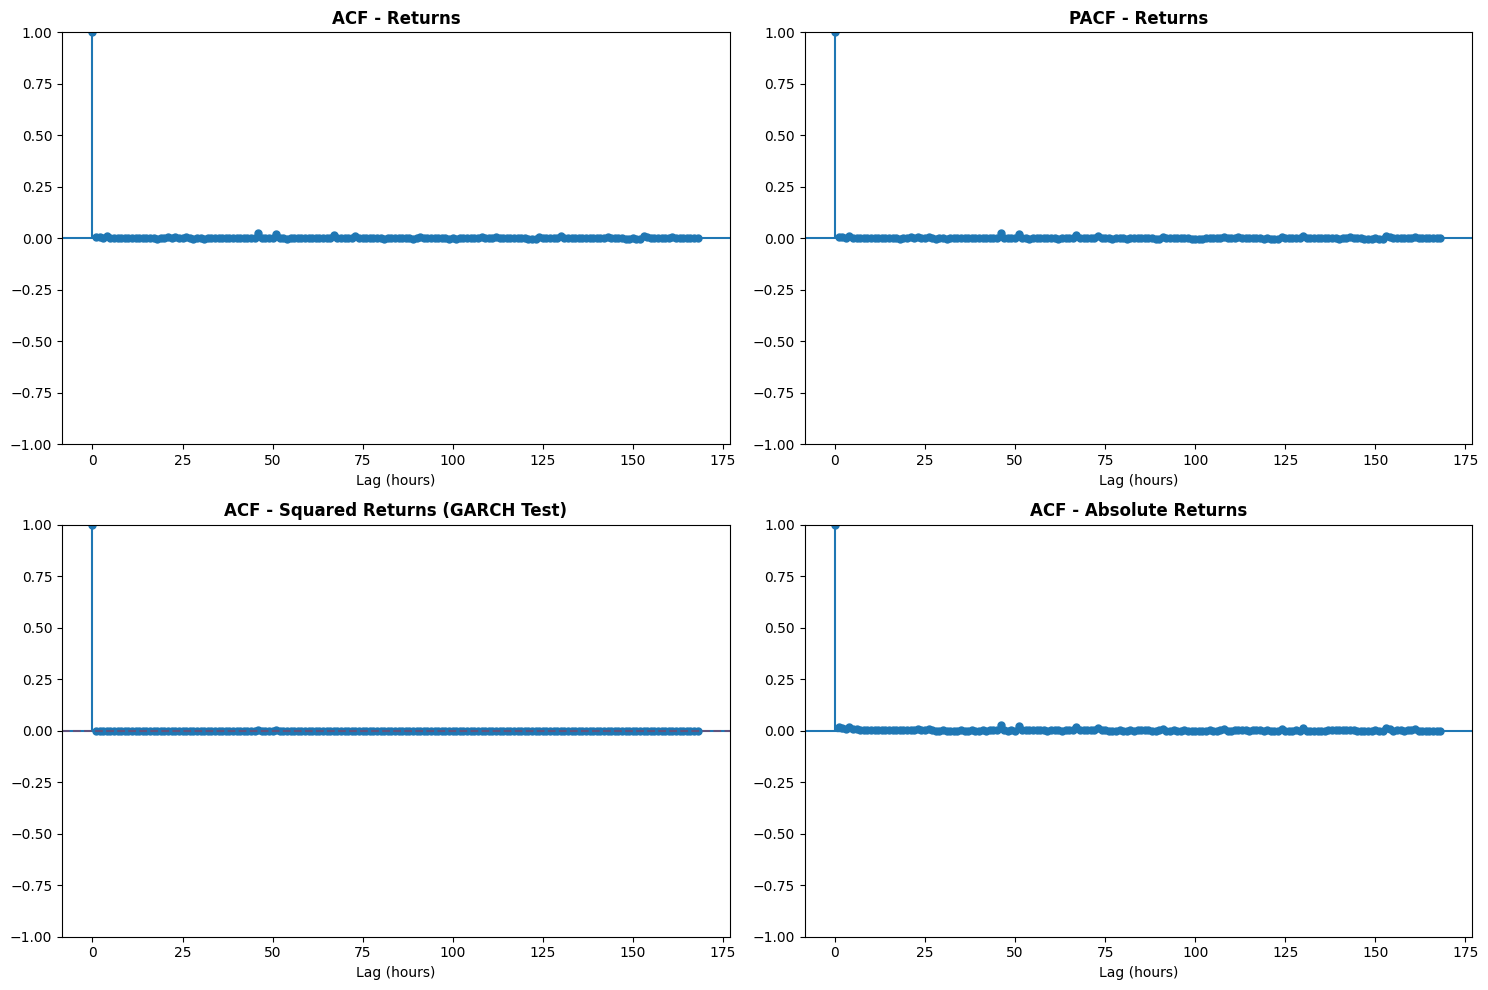

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ACF - Returns
plot_acf(df['returns'].dropna(), lags=168, ax=axes[0, 0], alpha=0.05)
axes[0, 0].set_title('ACF - Returns', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Lag (hours)')

# PACF - Returns
plot_pacf(df['returns'].dropna(), lags=168, ax=axes[0, 1], alpha=0.05, method='ywm')
axes[0, 1].set_title('PACF - Returns', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Lag (hours)')

# ACF - Squared returns (GARCH signature!)
plot_acf(df['returns'].dropna()**2, lags=168, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('ACF - Squared Returns (GARCH Test)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Lag (hours)')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.3)

# ACF - Absolute returns
plot_acf(np.abs(df['returns'].dropna()), lags=168, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('ACF - Absolute Returns', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Lag (hours)')

plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'eda' / '05_acf_pacf_returns_garch.png', dpi=300, bbox_inches='tight')
plt.show()


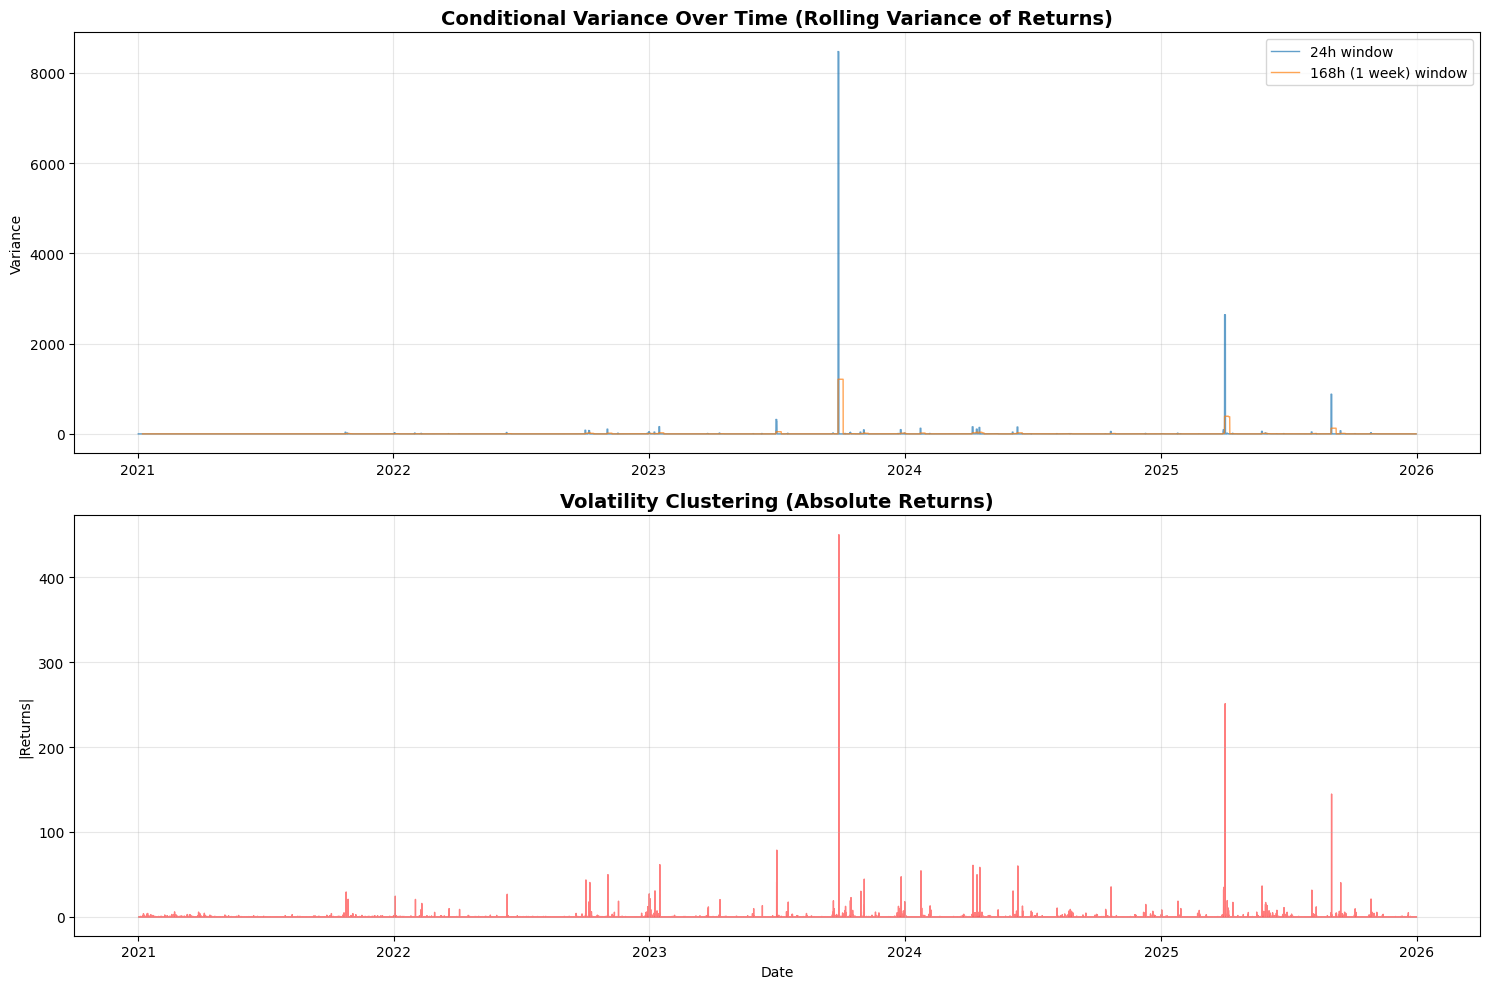

In [12]:
# Calculate rolling variance of returns (proxy for conditional variance)
rolling_var_24h = df['returns'].rolling(window=24).var()
rolling_var_168h = df['returns'].rolling(window=168).var()

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Rolling variance
axes[0].plot(df.index, rolling_var_24h, label='24h window', alpha=0.7, linewidth=1)
axes[0].plot(df.index, rolling_var_168h, label='168h (1 week) window', alpha=0.7, linewidth=1)
axes[0].set_title('Conditional Variance Over Time (Rolling Variance of Returns)', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Variance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volatility clustering visualization
axes[1].fill_between(df.index, 0, np.abs(df['returns']), alpha=0.5, color='red')
axes[1].set_title('Volatility Clustering (Absolute Returns)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('|Returns|')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'eda' / '06_conditional_variance.png', dpi=300, bbox_inches='tight')
plt.show()


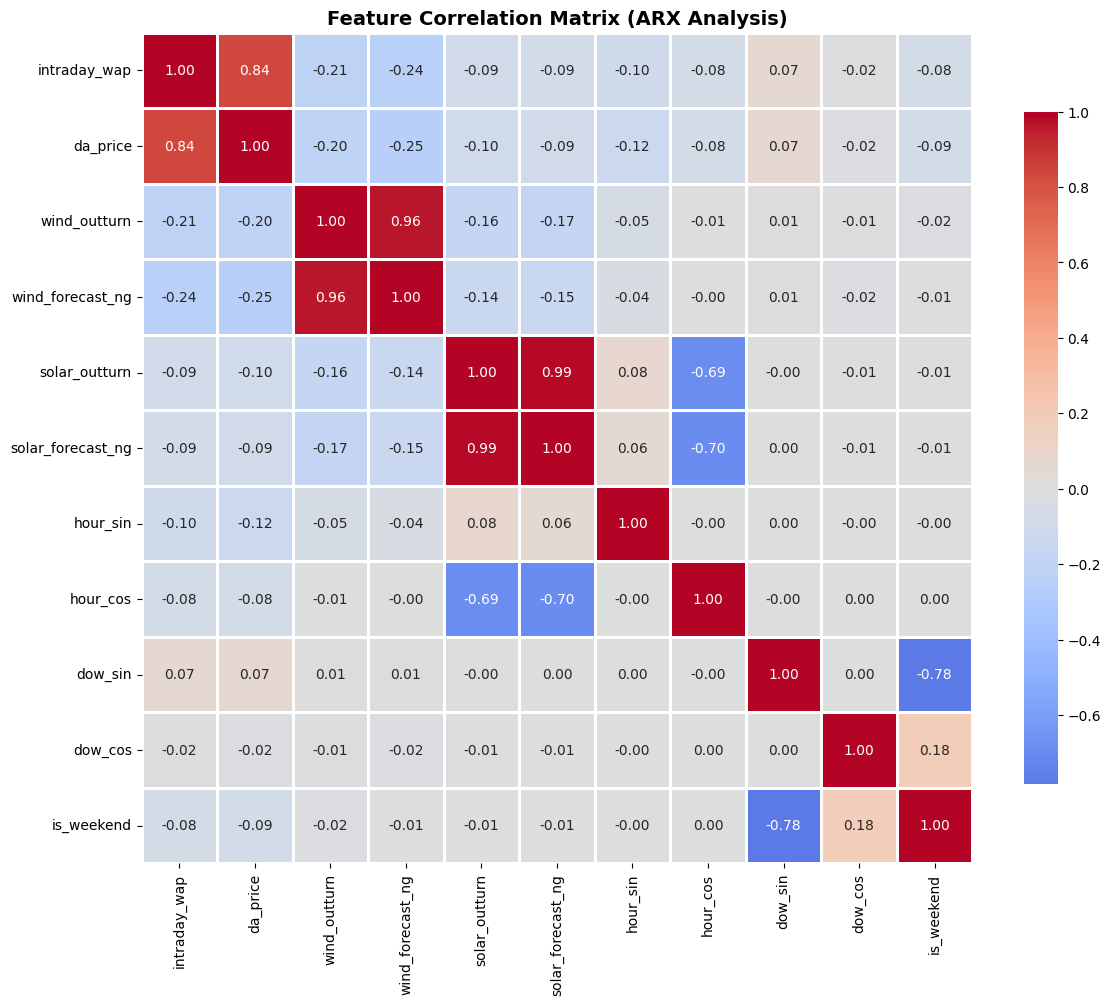

In [13]:
# Select relevant columns for correlation
corr_cols = [TARGET_COL, 'da_price', 'wind_outturn', 'wind_forecast_ng', 'solar_outturn', 
             'solar_forecast_ng', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 
             'is_weekend']

corr_matrix = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Feature Correlation Matrix (ARX Analysis)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'eda' / '07_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

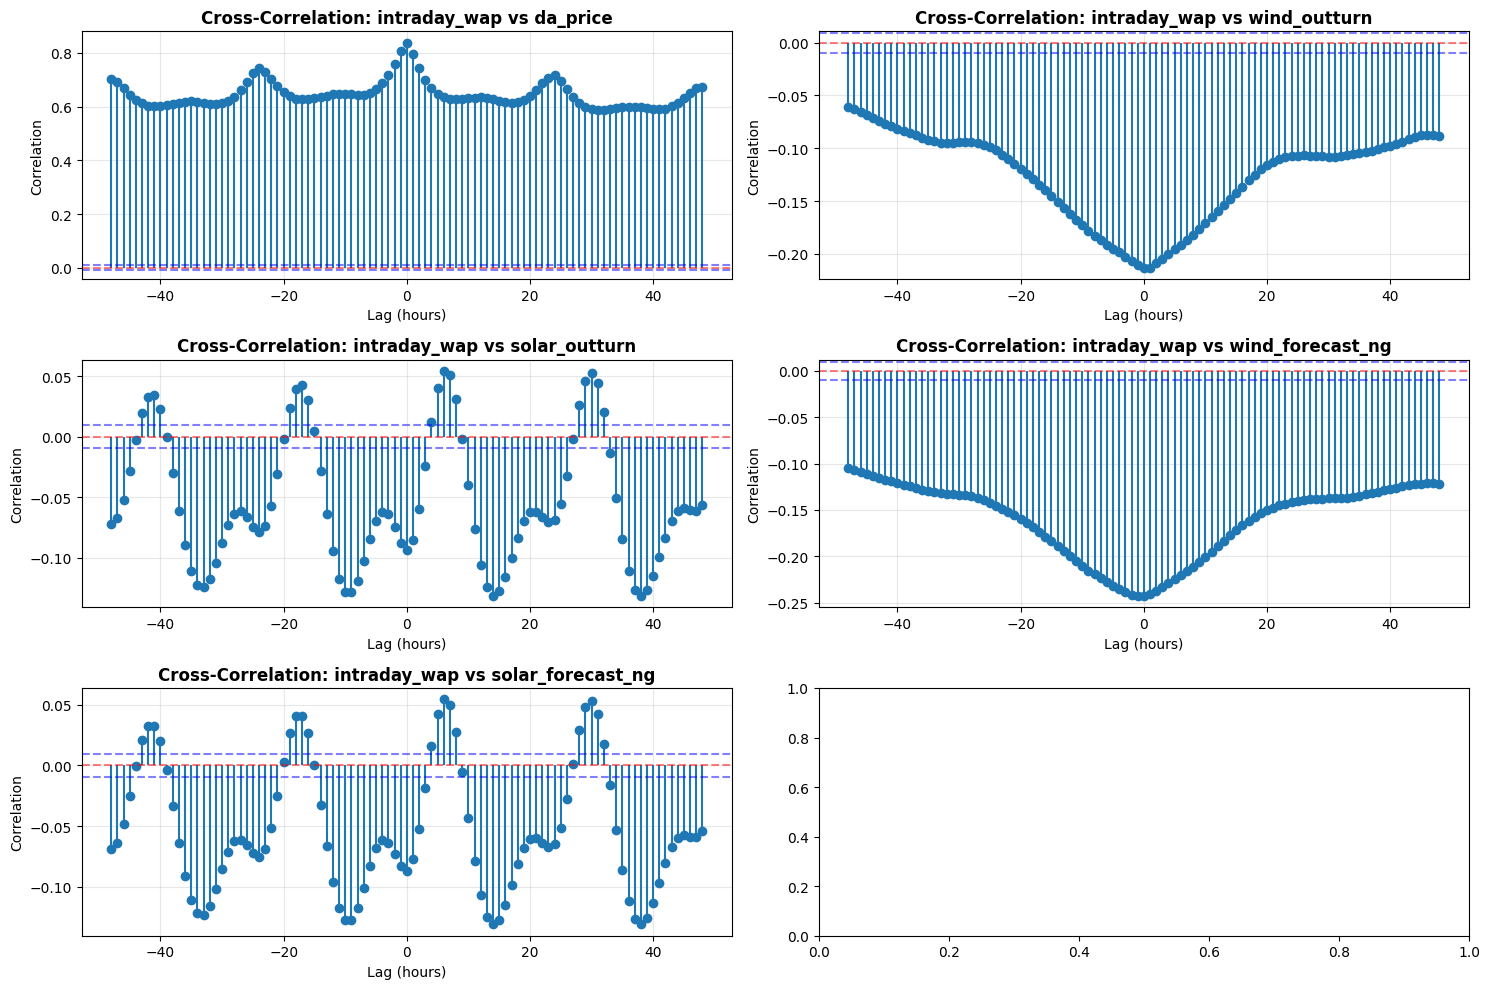

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

exog_vars = ['da_price', 'wind_outturn', 'solar_outturn', 'wind_forecast_ng', 'solar_forecast_ng']

for idx, var in enumerate(exog_vars):
    row = idx // 2
    col = idx % 2
    
    # Calculate cross-correlation
    ccf_values = [df[TARGET_COL].corr(df[var].shift(lag)) for lag in range(-48, 49)]
    lags = list(range(-48, 49))
    
    axes[row, col].stem(lags, ccf_values, basefmt=' ')
    axes[row, col].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[row, col].axhline(y=1.96/np.sqrt(len(df)), color='blue', linestyle='--', alpha=0.5)
    axes[row, col].axhline(y=-1.96/np.sqrt(len(df)), color='blue', linestyle='--', alpha=0.5)
    axes[row, col].set_title(f'Cross-Correlation: {TARGET_COL} vs {var}', fontweight='bold')
    axes[row, col].set_xlabel('Lag (hours)')
    axes[row, col].set_ylabel('Correlation')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'eda' / '08_cross_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


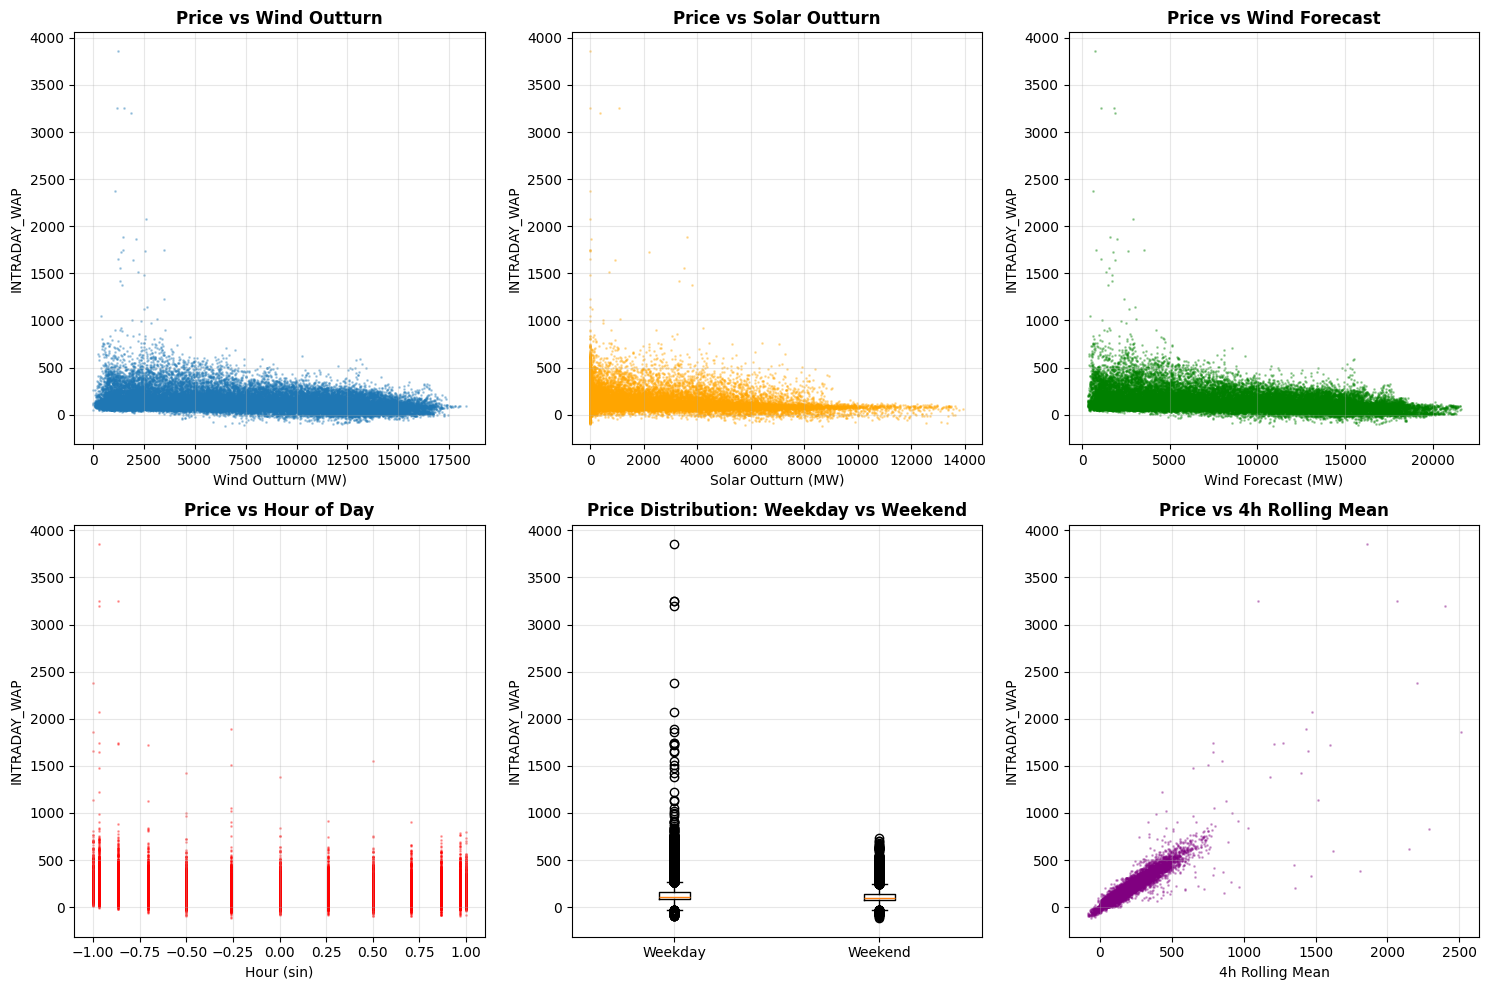

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Wind outturn
axes[0, 0].scatter(df['wind_outturn'], df[TARGET_COL], alpha=0.3, s=1)
axes[0, 0].set_xlabel('Wind Outturn (MW)')
axes[0, 0].set_ylabel(f'{TARGET_COL.upper()}')
axes[0, 0].set_title('Price vs Wind Outturn', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Solar outturn
axes[0, 1].scatter(df['solar_outturn'], df[TARGET_COL], alpha=0.3, s=1, color='orange')
axes[0, 1].set_xlabel('Solar Outturn (MW)')
axes[0, 1].set_ylabel(f'{TARGET_COL.upper()}')
axes[0, 1].set_title('Price vs Solar Outturn', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Wind forecast
axes[0, 2].scatter(df['wind_forecast_ng'], df[TARGET_COL], alpha=0.3, s=1, color='green')
axes[0, 2].set_xlabel('Wind Forecast (MW)')
axes[0, 2].set_ylabel(f'{TARGET_COL.upper()}')
axes[0, 2].set_title('Price vs Wind Forecast', fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# Hour (using hour_sin as proxy)
axes[1, 0].scatter(df['hour_sin'], df[TARGET_COL], alpha=0.3, s=1, color='red')
axes[1, 0].set_xlabel('Hour (sin)')
axes[1, 0].set_ylabel(f'{TARGET_COL.upper()}')
axes[1, 0].set_title('Price vs Hour of Day', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Weekend
weekend_prices = df[df['is_weekend']][TARGET_COL]
weekday_prices = df[~df['is_weekend']][TARGET_COL]
axes[1, 1].boxplot([weekday_prices, weekend_prices], labels=['Weekday', 'Weekend'])
axes[1, 1].set_ylabel(f'{TARGET_COL.upper()}')
axes[1, 1].set_title('Price Distribution: Weekday vs Weekend', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Rolling features
axes[1, 2].scatter(df['intraday_wap_rollmean_4'], df[TARGET_COL], alpha=0.3, s=1, color='purple')
axes[1, 2].set_xlabel('4h Rolling Mean')
axes[1, 2].set_ylabel(f'{TARGET_COL.upper()}')
axes[1, 2].set_title('Price vs 4h Rolling Mean', fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(project_root/ 'outputs' / 'eda' / '09_scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()

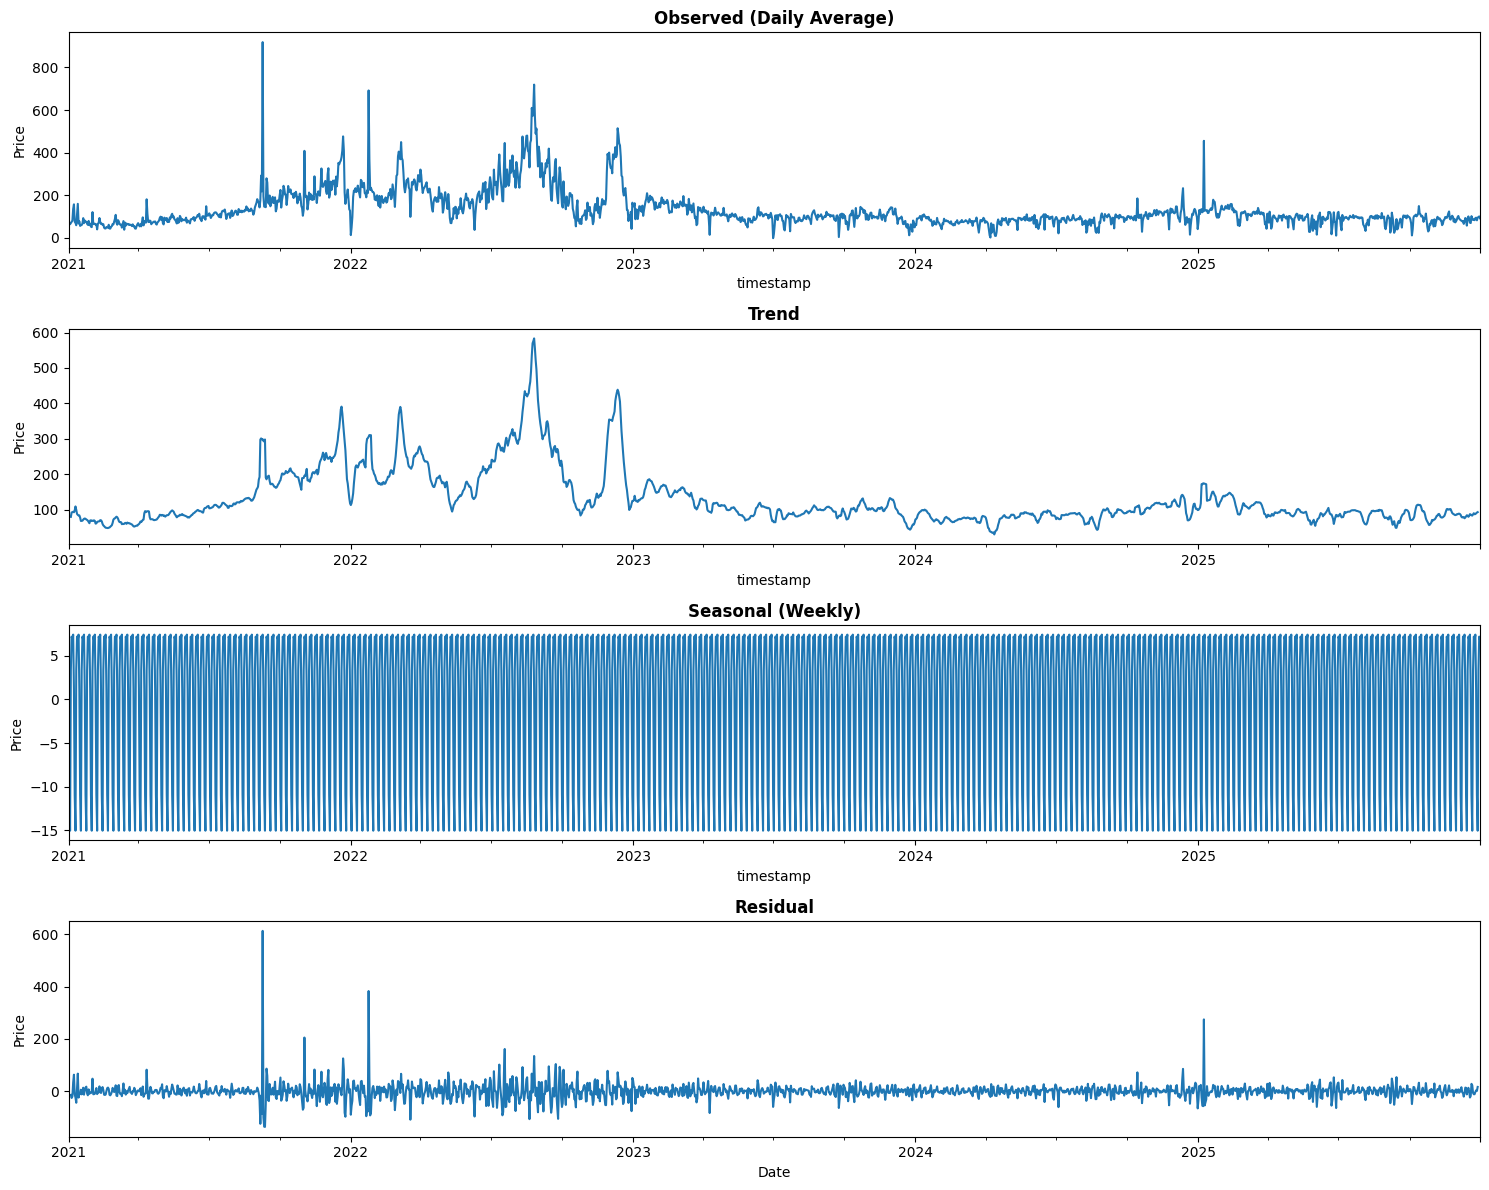

In [16]:
# Use a subset for decomposition (daily frequency for clearer patterns)
df_daily = df[TARGET_COL].resample('D').mean()

# Decompose with 7-day period (weekly seasonality)
decomposition = seasonal_decompose(df_daily, model='additive', period=7)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=axes[0])
axes[0].set_title('Observed (Daily Average)', fontweight='bold')
axes[0].set_ylabel('Price')

decomposition.trend.plot(ax=axes[1])
axes[1].set_title('Trend', fontweight='bold')
axes[1].set_ylabel('Price')

decomposition.seasonal.plot(ax=axes[2])
axes[2].set_title('Seasonal (Weekly)', fontweight='bold')
axes[2].set_ylabel('Price')

decomposition.resid.plot(ax=axes[3])
axes[3].set_title('Residual', fontweight='bold')
axes[3].set_ylabel('Price')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'eda' / '10_seasonal_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

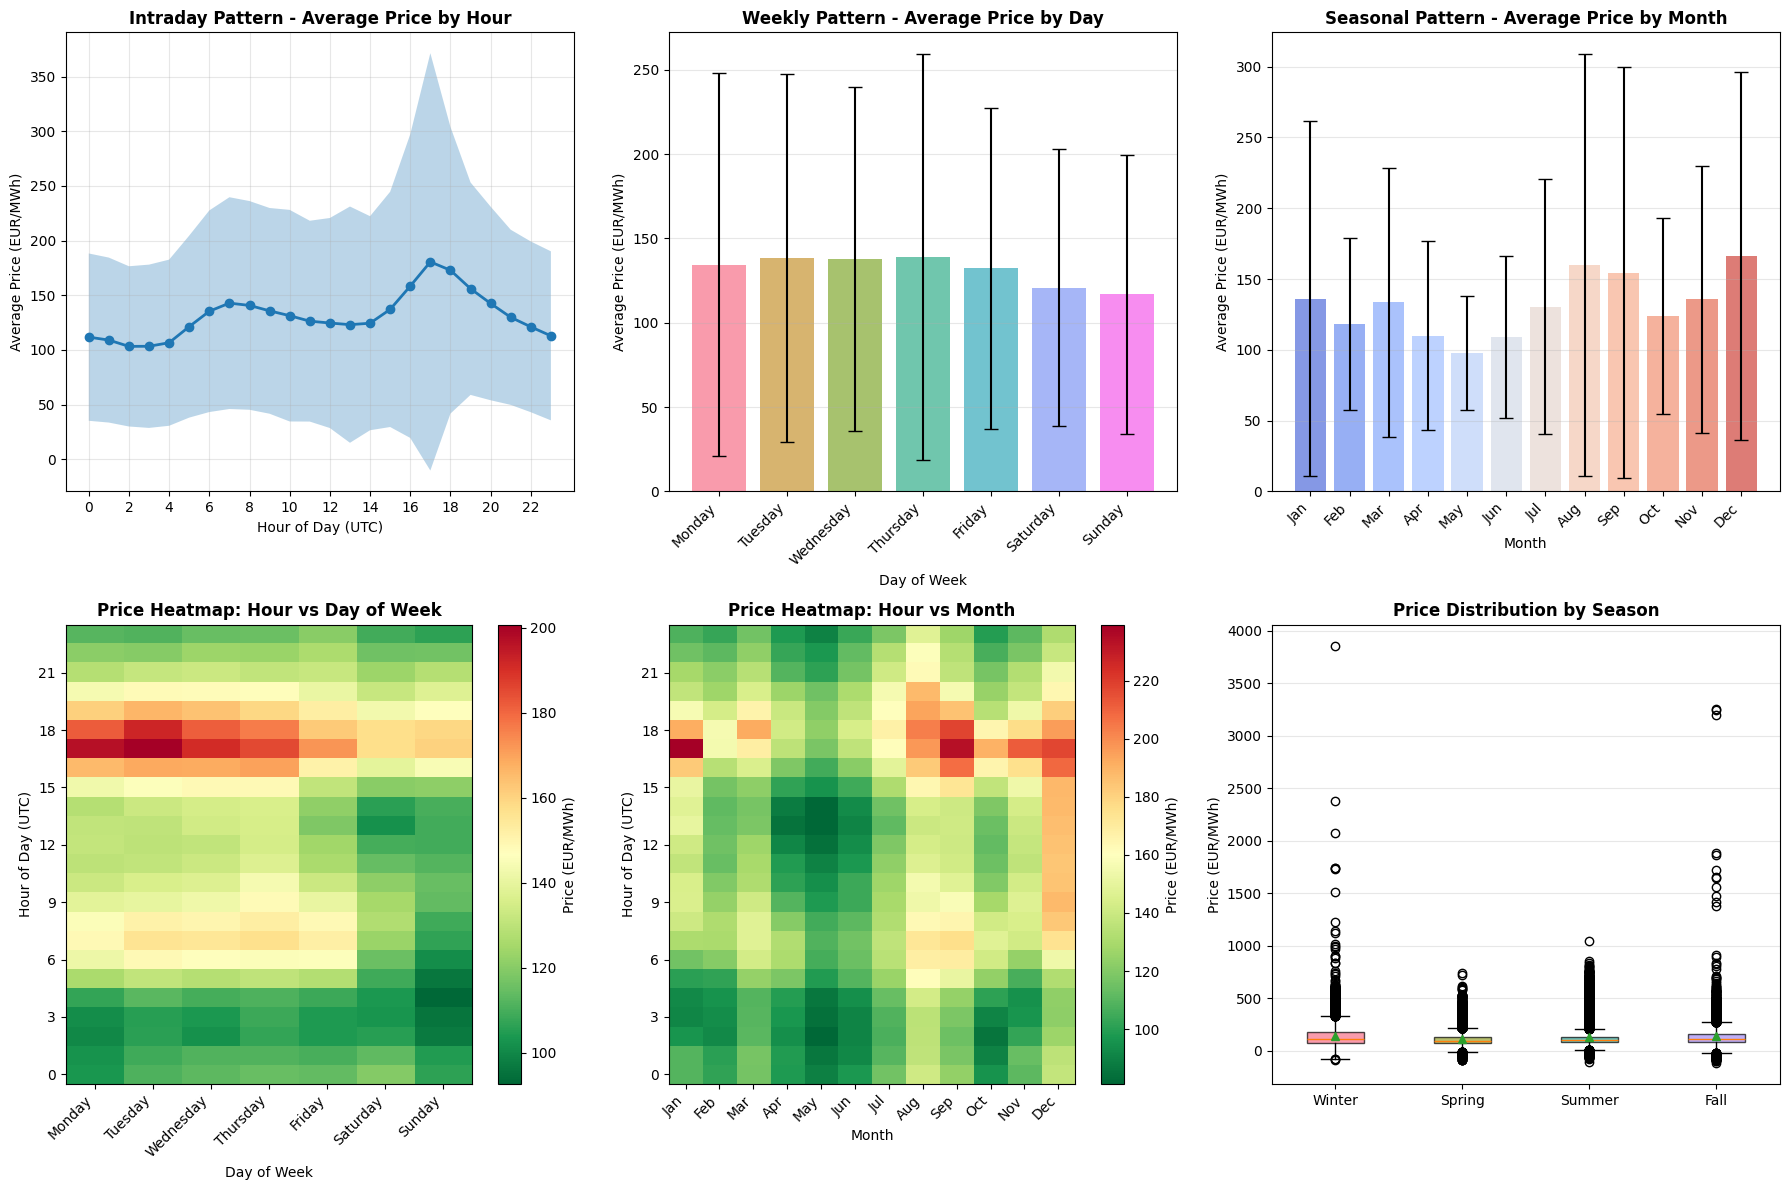


TEMPORAL PATTERN STATISTICS

📅 Hourly Pattern:
  Peak hour: 17:00 UTC (avg: 180.54 EUR/MWh)
  Lowest hour: 02:00 UTC (avg: 103.20 EUR/MWh)
  Peak-to-trough: 77.34 EUR/MWh

📆 Weekly Pattern:
  Highest day: Thursday (avg: 138.86 EUR/MWh)
  Lowest day: Sunday (avg: 116.95 EUR/MWh)
  Weekend avg: 118.91 EUR/MWh
  Weekday avg: 136.32 EUR/MWh

🌡️ Seasonal Pattern:
  Highest month: Dec (avg: 166.47 EUR/MWh)
  Lowest month: May (avg: 97.76 EUR/MWh)
  Winter avg: 140.78 EUR/MWh
  Spring avg: 113.84 EUR/MWh
  Summer avg: 133.32 EUR/MWh
  Fall avg: 137.86 EUR/MWh


In [17]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Average price by hour of day
hourly_avg = df.groupby(df.index.hour)[TARGET_COL].mean()
hourly_std = df.groupby(df.index.hour)[TARGET_COL].std()

axes[0, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=6)
axes[0, 0].fill_between(hourly_avg.index, 
                         hourly_avg - hourly_std, 
                         hourly_avg + hourly_std, 
                         alpha=0.3)
axes[0, 0].set_xlabel('Hour of Day (UTC)')
axes[0, 0].set_ylabel('Average Price (EUR/MWh)')
axes[0, 0].set_title('Intraday Pattern - Average Price by Hour', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(0, 24, 2))

# 2. Average price by day of week
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_avg = df.groupby(df.index.dayofweek)[TARGET_COL].mean()
weekly_std = df.groupby(df.index.dayofweek)[TARGET_COL].std()

axes[0, 1].bar(range(7), weekly_avg.values, yerr=weekly_std.values, 
               capsize=5, alpha=0.7, color=sns.color_palette("husl", 7))
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Average Price (EUR/MWh)')
axes[0, 1].set_title('Weekly Pattern - Average Price by Day', fontweight='bold')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Average price by month
monthly_avg = df.groupby(df.index.month)[TARGET_COL].mean()
monthly_std = df.groupby(df.index.month)[TARGET_COL].std()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

axes[0, 2].bar(range(1, 13), monthly_avg.values, yerr=monthly_std.values,
               capsize=5, alpha=0.7, color=sns.color_palette("coolwarm", 12))
axes[0, 2].set_xlabel('Month')
axes[0, 2].set_ylabel('Average Price (EUR/MWh)')
axes[0, 2].set_title('Seasonal Pattern - Average Price by Month', fontweight='bold')
axes[0, 2].set_xticks(range(1, 13))
axes[0, 2].set_xticklabels(month_names, rotation=45, ha='right')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Heatmap: Hour vs Day of Week
pivot_hour_dow = df.pivot_table(values=TARGET_COL, 
                                 index=df.index.hour, 
                                 columns=df.index.dayofweek, 
                                 aggfunc='mean')
pivot_hour_dow.columns = day_names

im = axes[1, 0].imshow(pivot_hour_dow.values, aspect='auto', cmap='RdYlGn_r', origin='lower')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Hour of Day (UTC)')
axes[1, 0].set_title('Price Heatmap: Hour vs Day of Week', fontweight='bold')
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(day_names, rotation=45, ha='right')
axes[1, 0].set_yticks(range(0, 24, 3))
axes[1, 0].set_yticklabels(range(0, 24, 3))
plt.colorbar(im, ax=axes[1, 0], label='Price (EUR/MWh)')

# 5. Heatmap: Month vs Hour
pivot_month_hour = df.pivot_table(values=TARGET_COL, 
                                   index=df.index.hour, 
                                   columns=df.index.month, 
                                   aggfunc='mean')
pivot_month_hour.columns = month_names

im2 = axes[1, 1].imshow(pivot_month_hour.values, aspect='auto', cmap='RdYlGn_r', origin='lower')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Hour of Day (UTC)')
axes[1, 1].set_title('Price Heatmap: Hour vs Month', fontweight='bold')
axes[1, 1].set_xticks(range(12))
axes[1, 1].set_xticklabels(month_names, rotation=45, ha='right')
axes[1, 1].set_yticks(range(0, 24, 3))
axes[1, 1].set_yticklabels(range(0, 24, 3))
plt.colorbar(im2, ax=axes[1, 1], label='Price (EUR/MWh)')

# 6. Box plot: Price distribution by season
df['season'] = df.index.month % 12 // 3 + 1
season_names = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df['season_name'] = df['season'].map(season_names)

season_data = [df[df['season_name'] == season][TARGET_COL].values 
               for season in ['Winter', 'Spring', 'Summer', 'Fall']]

bp = axes[1, 2].boxplot(season_data, labels=['Winter', 'Spring', 'Summer', 'Fall'],
                        patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], sns.color_palette("husl", 4)):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1, 2].set_ylabel('Price (EUR/MWh)')
axes[1, 2].set_title('Price Distribution by Season', fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'eda' / '11_temporal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("TEMPORAL PATTERN STATISTICS")
print("="*60)

print("\n📅 Hourly Pattern:")
print(f"  Peak hour: {hourly_avg.idxmax():02d}:00 UTC (avg: {hourly_avg.max():.2f} EUR/MWh)")
print(f"  Lowest hour: {hourly_avg.idxmin():02d}:00 UTC (avg: {hourly_avg.min():.2f} EUR/MWh)")
print(f"  Peak-to-trough: {hourly_avg.max() - hourly_avg.min():.2f} EUR/MWh")

print("\n📆 Weekly Pattern:")
print(f"  Highest day: {day_names[weekly_avg.idxmax()]} (avg: {weekly_avg.max():.2f} EUR/MWh)")
print(f"  Lowest day: {day_names[weekly_avg.idxmin()]} (avg: {weekly_avg.min():.2f} EUR/MWh)")
print(f"  Weekend avg: {df[df['is_weekend']][TARGET_COL].mean():.2f} EUR/MWh")
print(f"  Weekday avg: {df[~df['is_weekend']][TARGET_COL].mean():.2f} EUR/MWh")

print("\n🌡️ Seasonal Pattern:")
print(f"  Highest month: {month_names[monthly_avg.idxmax()-1]} (avg: {monthly_avg.max():.2f} EUR/MWh)")
print(f"  Lowest month: {month_names[monthly_avg.idxmin()-1]} (avg: {monthly_avg.min():.2f} EUR/MWh)")
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    season_avg = df[df['season_name'] == season][TARGET_COL].mean()
    print(f"  {season} avg: {season_avg:.2f} EUR/MWh")

In [18]:
summary_stats = pd.DataFrame({
    'Price Levels': df[TARGET_COL].describe(),
    'Returns': df['returns'].describe(),
    'Log Returns': df['log_returns'].describe(),
})

print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(summary_stats)

print("\n" + "="*60)
print("MODEL SUITABILITY INDICATORS")
print("="*60)

# ARIMA indicators
print("\n📊 ARIMA Eligibility:")
print(f"  • Non-stationarity detected in levels: Check rolling mean plot")
print(f"  • ACF decay pattern: Check ACF plots for exponential/sinusoidal decay")
print(f"  • Suggested differencing: d=1 (first difference shows more stationarity)")

# GARCH indicators
print("\n📈 GARCH Eligibility:")
print(f"  • Kurtosis of returns: {stats.kurtosis(df['returns'].dropna()):.2f} (>3 → fat tails ✓)")
print(f"  • Volatility clustering visible: Check absolute returns plot")
print(f"  • ACF of squared returns: Check if significant → GARCH needed")

# ARX indicators
print("\n🔗 ARX Eligibility:")
print(f"  • Wind-price correlation: {df[TARGET_COL].corr(df['wind_outturn']):.3f}")
print(f"  • Solar-price correlation: {df[TARGET_COL].corr(df['solar_outturn']):.3f}")
print(f"  • Check cross-correlation plots for optimal lag structure")

print("\n" + "="*60)


SUMMARY STATISTICS
       Price Levels       Returns   Log Returns
count  43146.000000  43146.000000  43146.000000
mean     131.383065      0.103408     -0.000639
std      102.077022      2.881245      0.337700
min     -115.530000     -0.999474     -7.549609
25%       80.712500     -0.095252     -0.100098
50%      105.000000     -0.004307     -0.004317
75%      152.437500      0.100847      0.096080
max     3859.630000    451.000000      6.113682

MODEL SUITABILITY INDICATORS

📊 ARIMA Eligibility:
  • Non-stationarity detected in levels: Check rolling mean plot
  • ACF decay pattern: Check ACF plots for exponential/sinusoidal decay
  • Suggested differencing: d=1 (first difference shows more stationarity)

📈 GARCH Eligibility:
  • Kurtosis of returns: 15446.63 (>3 → fat tails ✓)
  • Volatility clustering visible: Check absolute returns plot
  • ACF of squared returns: Check if significant → GARCH needed

🔗 ARX Eligibility:
  • Wind-price correlation: -0.213
  • Solar-price correlation